# Pemodelan XGBoost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snsz
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import xgboost as xgb
from geopy.distance import geodesic
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, roc_curve, f1_score, recall_score, precision_score

In [ ]:
 df = pd.read_csv('dataset.csv')
 df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [ ]:
# Convert trans_date_trans_time column to datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

# Extract hour from datetime
df['hour'] = df['trans_date_trans_time'].dt.hour

# Extract day from datetime
df['day'] = df['trans_date_trans_time'].dt.day

# Extract month from datetime
df['month'] = df['trans_date_trans_time'].dt.month

In [ ]:
# Define columns to drop
drop_columns = ['Unnamed: 0', 'trans_date_trans_time', 'first', 'last', 'street', 'city', 'state', 'zip', 'dob', 'job', 'trans_num']

# Drop the specified columns from dataframe
df = df.drop(columns=drop_columns)

In [ ]:
df.head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,hour,day,month
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,0,1,1
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,0,1,1
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,0,1,1
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,0,1,1
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,0,1,1


In [ ]:
# Import LabelEncoder from sklearn.preprocessing
from sklearn.preprocessing import LabelEncoder

cat_col = ['merchant', 'category', 'gender']
encoders = {}
for col in cat_col:
    encoders[col]=LabelEncoder()
    df[col]=encoders[col].fit_transform(df[col])

In [ ]:
import numpy as np
from geopy.distance import geodesic

def haversine(lat1, lon1, lat2, lon2):
    return np.array([
        geodesic((a, b), (c, d)).km if np.isfinite(a) and np.isfinite(b) and np.isfinite(c) and np.isfinite(d)
        else np.nan
        for a, b, c, d in zip(lat1, lon1, lat2, lon2)
    ])

df['distance'] = haversine(df['lat'], df['long'], df['merch_lat'], df['merch_long'])


In [ ]:
df.head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,hour,day,month,distance
0,2703186189652095,514,8,4.97,0,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,0,1,1,78.773821
1,630423337322,241,4,107.23,0,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,0,1,1,30.216618
2,38859492057661,390,0,220.11,1,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,0,1,1,108.102912
3,3534093764340240,360,2,45.00,1,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,0,1,1,95.685115
4,375534208663984,297,9,41.96,1,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,0,1,1,77.702395


In [ ]:
features = ['merchant','category','amt','cc_num','hour','day','month','gender','distance']
x = df[features]
y=df['is_fraud']

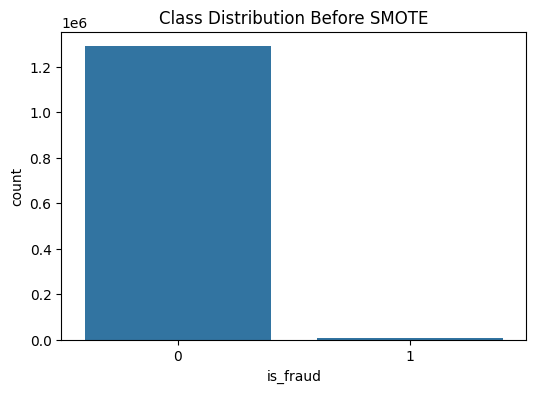

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x='is_fraud', data=df)
plt.title("Class Distribution Before SMOTE")
plt.show()


In [ ]:
# Check for missing values in the target variable
print(f"Missing values in 'is_fraud' before dropping: {df['is_fraud'].isnull().sum()}")

# Drop rows where 'is_fraud' is NaN
df.dropna(subset=['is_fraud'], inplace=True)

# Re-create features and target variables after dropping rows
features = ['merchant','category','amt','cc_num','hour','day','month','gender','distance']
x = df[features]
y=df['is_fraud']

# Check for missing values in the target variable again
print(f"Missing values in 'is_fraud' after dropping: {df['is_fraud'].isnull().sum()}")

# Now apply SMOTE
smote = SMOTE(random_state=42)
x_resample, y_resample = smote.fit_resample(x,y)

Missing values in 'is_fraud' before dropping: 0
Missing values in 'is_fraud' after dropping: 0


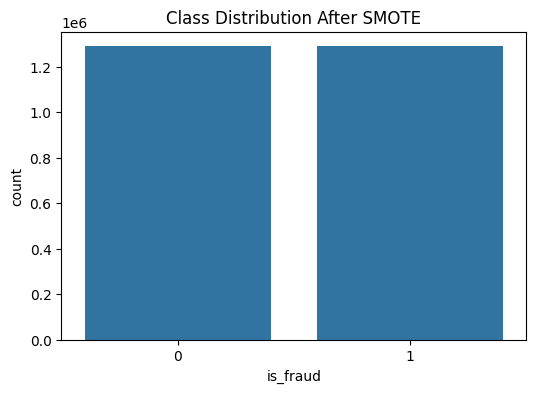

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_resample)
plt.title("Class Distribution After SMOTE")
plt.show()

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_resample, y_resample, test_size=0.2, random_state=42)

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False
)

xgb_model.fit(x_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:45:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred = xgb_model.predict(x_test)

In [ ]:
print("Classification_Report:\n", classification_report(y_test,y_pred))
print("Roc AUC Score: ", roc_auc_score(y_test, y_pred))

Classification_Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95    257186
           1       0.97      0.92      0.94    258482

    accuracy                           0.95    515668
   macro avg       0.95      0.95      0.95    515668
weighted avg       0.95      0.95      0.95    515668

Roc AUC Score:  0.9452918010765666


<Figure size 1000x600 with 0 Axes>

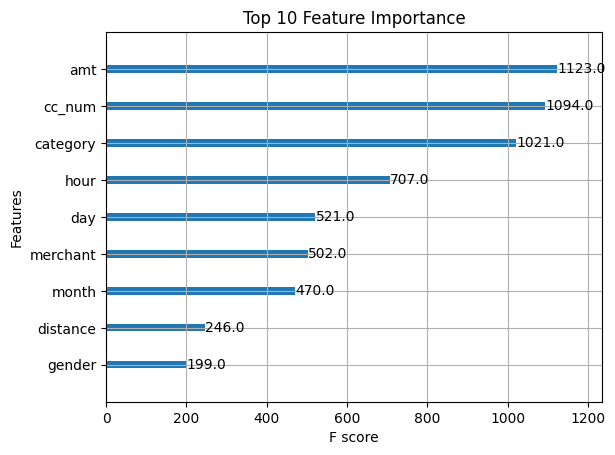

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

plt.figure(figsize=(10, 6))  # atur ukuran figure di sini
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='weight')
plt.title("Top 10 Feature Importance")
plt.show()


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, xgb_model.predict_proba(x_test)[:,1])
roc_auc = auc(fpr, tpr)


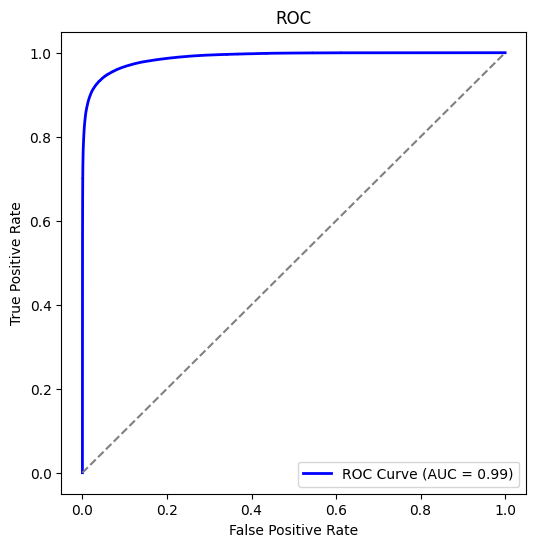

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


In [ ]:
 import joblib

joblib.dump(xgb_model, "fraud_detection_model.jb")
joblib.dump(encoders, "label_encoder.jb")  # pastikan variabel 'encoders' sudah didefinisikan


['label_encoder.jb']

# app.py

In [52]:
!pip install streamlit pyngrok


In [59]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib
from geopy.distance import geodesic

# Load trained model & encoder dictionary
model = joblib.load('fraud_detection_model.jb')
encoder = joblib.load('label_encoder.jb')  # encoder adalah dictionary: {'merchant': LabelEncoder, ...}

def haversine(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km

# --- Streamlit App Layout ---
st.title("Fraud Detection App")
st.write("Enter the transaction details to predict if it's fraudulent.")

# Input fields untuk memasukkan data transaksi
merchant = st.text_input("Merchant")
category = st.text_input("Category")
amt = st.number_input("Amount", value=0.0)
lat = st.number_input("Latitude", value=0.0)
long = st.number_input("Longitude", value=0.0)
merch_lat = st.number_input("Merchant Latitude", value=0.0)
merch_long = st.number_input("Merchant Longitude", value=0.0)
hour = st.slider("Hour", 0, 23, 12)
day = st.slider("Day", 1, 31, 15)
month = st.slider("Month", 1, 12, 6)
gender = st.selectbox("Gender", ["M", "F"])
cc_num = st.text_input("Credit Card Number")

# Hitung jarak
distance = haversine(lat, long, merch_lat, merch_long)

# Tombol Prediksi
if st.button("Predict"):
    # Pastikan field yang wajib diisi sudah ada nilainya
    if merchant and category and cc_num:
        # Buat DataFrame input
        input_data = pd.DataFrame([[merchant, category, amt, distance, hour, day, month, gender, cc_num]],
                                   columns=['merchant', 'category', 'amt', 'distance', 'hour', 'day', 'month', 'gender', 'cc_num'])

        # Kolom kategorikal yang perlu di-encode
        categorical_columns = ['merchant', 'category', 'gender']

        # Proses encoding dengan tambahan pembersihan (strip) dan error handling
        for col in categorical_columns:
    val = str(input_data[col].iloc[0]).strip()  # Hapus spasi/tab tersembunyi

    st.write(f"🧪 CLEANED input for '{col}': '{val}'")
    st.write(f"✔️ Known classes: {encoder[col].classes_}")

    if val not in encoder[col].classes_:
        st.warning(f"Value '{val}' in column '{col}' not seen during training. Using fallback value -1.")
        input_data[col] = -1
    else:
        input_data[col] = encoder[col].transform([val])[0]


        # Proses hash untuk Credit Card Number
        input_data['cc_num'] = input_data['cc_num'].apply(lambda x: hash(x) % (10 ** 2))

        # Pastikan urutan kolom sesuai dengan data training
        features_order = ['merchant', 'category', 'amt', 'cc_num', 'hour', 'day', 'month', 'gender', 'distance']
        input_data = input_data[features_order]

        # Lakukan prediksi
        prediction = model.predict(input_data)[0]
        result = "Fraudulent Transaction" if prediction == 1 else "Legitimate Transaction"
        st.subheader(f"Prediction: {result}")
    else:
        st.warning("Please enter Merchant, Category, and Credit Card Number.")


Overwriting app.py
